# Baseline Model Fairness Analysis Documentation

**Model:** Baseline Convolutional Model (Initial Version)

---

This document provides an analysis of the Baseline Emotion Recognition Model, which served as the initial implementation before the Enhanced Model V2. The baseline model was trained on the FER and CK+ datasets to classify four emotions: anger, fear, calm, and surprise.

### Key Findings:

**Overall Performance:**
- Combined validation accuracy: 53.88%
- FER validation accuracy: 51.29%
- CK+ validation accuracy: 60.80%
- Training accuracy: 57.08%

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Define project paths
PROJECT_ROOT = '/Users/gregor/Documents/GitHub-Projects/EmoTorch_Paper'
BASELINE_MODEL_DIR = os.path.join(PROJECT_ROOT, 'baseline_model', 'model')
DATASET_PATH = os.path.join(BASELINE_MODEL_DIR, 'dataset_catalog.csv')

print("📊 Loading baseline model data...")
print(f"Project root: {PROJECT_ROOT}")
print(f"Baseline model directory: {BASELINE_MODEL_DIR}")

📊 Loading baseline model data...
Project root: /Users/gregor/Documents/GitHub-Projects/EmoTorch_Paper
Baseline model directory: /Users/gregor/Documents/GitHub-Projects/EmoTorch_Paper/baseline_model/model


---
## Part 1: Dataset Overview

Understanding the baseline dataset distribution and characteristics.

In [ ]:
# Load the dataset
df_all = pd.read_csv(DATASET_PATH)
print(f"Total images in catalog (including augmented): {len(df_all):,}")

# Filter to only non-augmented images (original dataset)
df = df_all[df_all['augmented'] == False].copy()
print(f"Original (non-augmented) images: {len(df):,}")

# Separate by dataset source
df_fer = df[df['image_paths'].str.contains('FER')]
df_ckp = df[df['image_paths'].str.contains('CKP|CK\\+', regex=True)]

print(f"\n📌 Dataset Composition (Original Images Only):")
print(f"  • FER dataset images: {len(df_fer):,}")
print(f"  • CK+ dataset images: {len(df_ckp):,}")

df.head()

Total images in catalog (including augmented): 1,067,940
Original (non-augmented) images: 20,940

📌 Dataset Composition (Original Images Only):
  • FER dataset images: 20,940
  • CK+ dataset images: 666


,image_paths,emotion,usage,race,race4,gender,age,augmented
0,FER-Original-Dataset/FER/anger/3975.png,anger,training,White,White,Female,40-49,False
1,FER-Original-Dataset/FER/anger/348.png,anger,training,White,Black,Male,3-9,False
2,FER-Original-Dataset/FER/anger/1804.png,anger,training,White,White,Male,40-49,False
3,FER-Original-Dataset/FER/anger/1810.png,anger,training,White,White,Male,30-39,False
4,FER-Original-Dataset/FER/anger/3961.png,anger,training,White,White,Male,30-39,False


### 1.1 Dataset Source Distribution

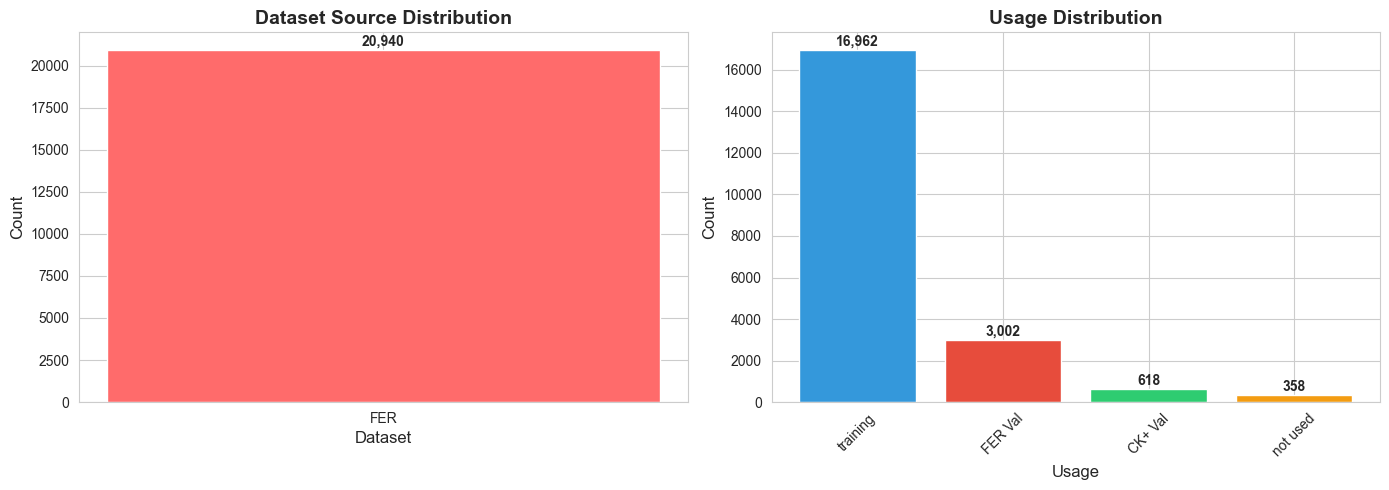


📊 Dataset Statistics:
  • Total images: 20,940
  • FER: 20,940 (100.0%)
  • CK+: 666 (3.2%)


In [ ]:
# Determine dataset source
def get_dataset_source(path):
    if 'FER' in path:
        return 'FER'
    elif 'CKP' in path or 'CK+' in path:
        return 'CK+'
    else:
        return 'Other'

df['dataset_source'] = df['image_paths'].apply(get_dataset_source)

# Count by usage type
usage_counts = df.groupby(['dataset_source', 'usage']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Dataset source distribution
ax1 = axes[0]
source_counts = df['dataset_source'].value_counts()
bars1 = ax1.bar(source_counts.index, source_counts.values, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Dataset Source Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Dataset', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

# Usage distribution
ax2 = axes[1]
usage_mapping = {
    'fer_training': 'FER Train',
    'ckp_training': 'CK+ Train',
    'fer_validation': 'FER Val',
    'ckp_validation': 'CK+ Val'
}
usage_counts_clean = df['usage'].value_counts()
usage_labels = [usage_mapping.get(x, x) for x in usage_counts_clean.index]
bars2 = ax2.bar(usage_labels, usage_counts_clean.values, color=['#3498DB', '#E74C3C', '#2ECC71', '#F39C12'])
ax2.set_title('Usage Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Usage', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Dataset Statistics:")
print(f"  • Total images: {len(df):,}")
print(f"  • FER: {len(df_fer):,} ({len(df_fer)/len(df)*100:.1f}%)")
print(f"  • CK+: {len(df_ckp):,} ({len(df_ckp)/len(df)*100:.1f}%)")

### 1.2 Emotion Distribution Analysis

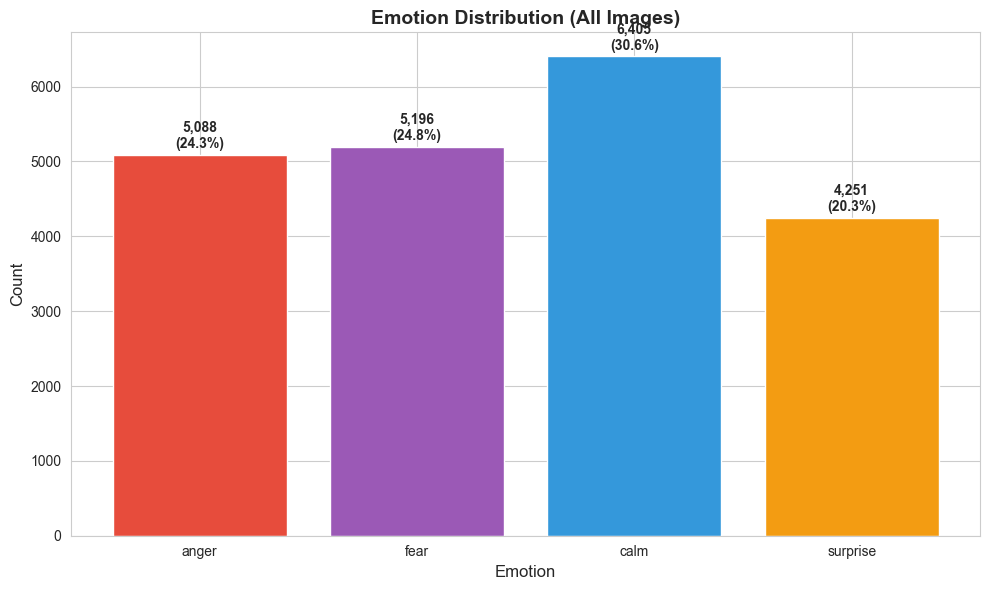


📊 Emotion Distribution:
  • anger     :  5,088 ( 24.3%)
  • fear      :  5,196 ( 24.8%)
  • calm      :  6,405 ( 30.6%)
  • surprise  :  4,251 ( 20.3%)


In [ ]:
# Get emotion distribution
emotion_counts = df['emotion'].value_counts()
emotion_order = ['anger', 'fear', 'calm', 'surprise']

# Filter to standard emotions if they exist
if all(emotion in emotion_counts.index for emotion in emotion_order):
    emotion_counts = emotion_counts[emotion_order]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colors = ['#E74C3C', '#9B59B6', '#3498DB', '#F39C12']
bars = ax.bar(emotion_counts.index, emotion_counts.values, color=colors)
ax.set_title('Emotion Distribution (All Images)', fontsize=14, fontweight='bold')
ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 50,
            f'{int(height):,}\n({height/len(df)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Emotion Distribution:")
for emotion, count in emotion_counts.items():
    print(f"  • {emotion:10}: {count:6,} ({count/len(df)*100:5.1f}%)")

### 1.3 Demographic Distributions

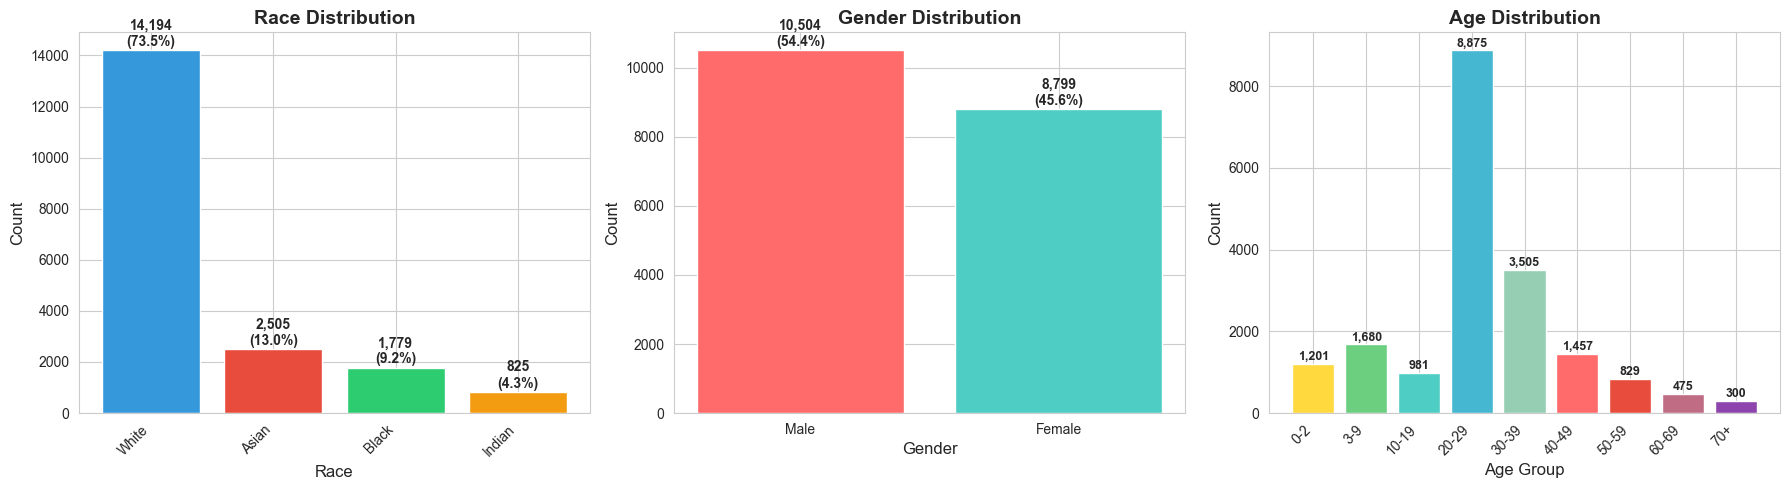


📊 Demographic Statistics:
  • Images with race data: 19,303 (92.2%)
  • Images with gender data: 19,303 (92.2%)
  • Images with age data: 19,303 (92.2%)


In [ ]:
# Prepare filtered datasets
df_race = df[df['race4'] != 'unclassified']
df_gender = df[df['gender'] != 'unclassified']
df_age = df[df['age'] != 'unclassified']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Race distribution
ax1 = axes[0]
race_counts = df_race['race4'].value_counts()
bars1 = ax1.bar(range(len(race_counts)), race_counts.values, color=['#3498DB', '#E74C3C', '#2ECC71', '#F39C12'][:len(race_counts)])
ax1.set_title('Race Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Race', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticks(range(len(race_counts)))
ax1.set_xticklabels(race_counts.index, rotation=45, ha='right')

for i, v in enumerate(race_counts.values):
    ax1.text(i, v + 50, f'{v:,}\n({v/len(df_race)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Gender distribution
ax2 = axes[1]
gender_counts = df_gender['gender'].value_counts()
bars2 = ax2.bar(gender_counts.index, gender_counts.values, color=['#FF6B6B', '#4ECDC4'])
ax2.set_title('Gender Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Gender', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)

for i, v in enumerate(gender_counts.values):
    ax2.text(i, v + 50, f'{v:,}\n({v/len(df_gender)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Age distribution
ax3 = axes[2]
age_order = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
age_counts = df_age['age'].value_counts()
# Reorder if all age groups exist
age_counts_ordered = pd.Series({age: age_counts.get(age, 0) for age in age_order if age in age_counts.index})
bars3 = ax3.bar(range(len(age_counts_ordered)), age_counts_ordered.values,
                color=['#FFD93D', '#6BCF7F', '#4ECDC4', '#45B7D1', '#96CEB4', '#FF6B6B', '#E74C3C', '#C06C84', '#8E44AD'][:len(age_counts_ordered)])
ax3.set_title('Age Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Age Group', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.set_xticks(range(len(age_counts_ordered)))
ax3.set_xticklabels(age_counts_ordered.index, rotation=45, ha='right')

for i, v in enumerate(age_counts_ordered.values):
    ax3.text(i, v + 20, f'{v:,}',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 Demographic Statistics:")
print(f"  • Images with race data: {len(df_race):,} ({len(df_race)/len(df)*100:.1f}%)")
print(f"  • Images with gender data: {len(df_gender):,} ({len(df_gender)/len(df)*100:.1f}%)")
print(f"  • Images with age data: {len(df_age):,} ({len(df_age)/len(df)*100:.1f}%)")

---
## Part 2: Baseline Model Performance

Analysis of the baseline model's overall performance characteristics.

📊 Baseline Model Performance Metrics:

🎯 Accuracy Metrics:
  • Training Accuracy: 57.08%
  • FER Validation Accuracy: 51.29%
  • CK+ Validation Accuracy: 60.80%
  • Combined Validation Accuracy: 53.88%

📊 Performance Analysis:
  • Dataset performance gap: 9.51%
  • CK+ performs 9.51% better than FER


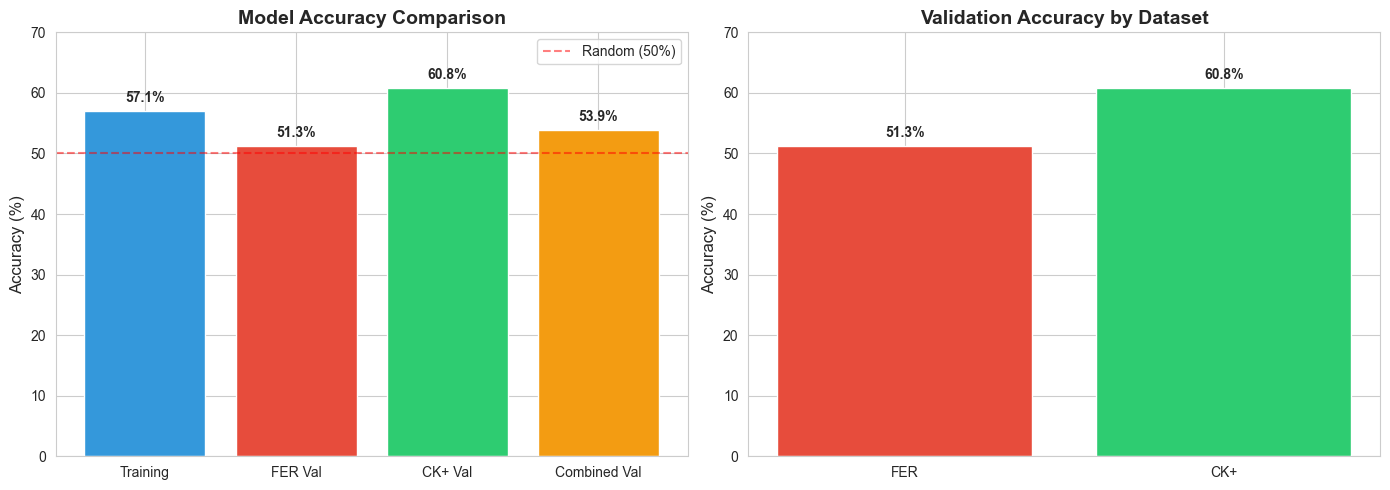


📋 Complete Metrics Table:
────────────────────────────────────────────────────────────
  Training Accuracy                   57.08
  Training Loss                       -0.6554
  FER Validation Accuracy             51.29
  FER Validation Loss                 -0.6168
  CKP Validation Accuracy             60.8
  CKP Validation Loss                 -0.6749
  Combined Validation Accuracy        53.88
  Combined Validation Loss            -0.6327
  Epochs Completed                    16.0
  Total Training Images               31364.0
  Total Validation Images             7604.0


In [ ]:
# Load performance metrics
accuracies_path = os.path.join(BASELINE_MODEL_DIR, 'final_accuracies.csv')

if os.path.exists(accuracies_path):
    acc_df = pd.read_csv(accuracies_path)

    print("📊 Baseline Model Performance Metrics:")
    print("="*60)

    # Extract key metrics
    train_acc = acc_df[acc_df['Metric'] == 'Training Accuracy']['Value'].values[0]
    fer_val_acc = acc_df[acc_df['Metric'] == 'FER Validation Accuracy']['Value'].values[0]
    ckp_val_acc = acc_df[acc_df['Metric'] == 'CKP Validation Accuracy']['Value'].values[0]
    combined_val_acc = acc_df[acc_df['Metric'] == 'Combined Validation Accuracy']['Value'].values[0]

    print(f"\n🎯 Accuracy Metrics:")
    print(f"  • Training Accuracy: {train_acc:.2f}%")
    print(f"  • FER Validation Accuracy: {fer_val_acc:.2f}%")
    print(f"  • CK+ Validation Accuracy: {ckp_val_acc:.2f}%")
    print(f"  • Combined Validation Accuracy: {combined_val_acc:.2f}%")

    print(f"\n📊 Performance Analysis:")
    dataset_gap = abs(ckp_val_acc - fer_val_acc)
    print(f"  • Dataset performance gap: {dataset_gap:.2f}%")
    print(f"  • CK+ performs {dataset_gap:.2f}% better than FER")

    # Visualize performance
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Overall accuracy comparison
    ax1 = axes[0]
    metrics = ['Training', 'FER Val', 'CK+ Val', 'Combined Val']
    values = [train_acc, fer_val_acc, ckp_val_acc, combined_val_acc]
    colors = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12']
    bars = ax1.bar(metrics, values, color=colors)
    ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_ylim([0, 70])
    ax1.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
    ax1.legend()

    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Dataset-specific comparison
    ax2 = axes[1]
    datasets = ['FER', 'CK+']
    dataset_vals = [fer_val_acc, ckp_val_acc]
    bars2 = ax2.bar(datasets, dataset_vals, color=['#E74C3C', '#2ECC71'])
    ax2.set_title('Validation Accuracy by Dataset', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_ylim([0, 70])

    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Display full metrics table
    print("\n📋 Complete Metrics Table:")
    print("─" * 60)
    for _, row in acc_df.iterrows():
        print(f"  {row['Metric']:<35} {row['Value']}")

### 2.1 Confusion Matrices Analysis

📊 Baseline Model Confusion Matrices:

The confusion matrices show per-class performance for FER and CK+ datasets:


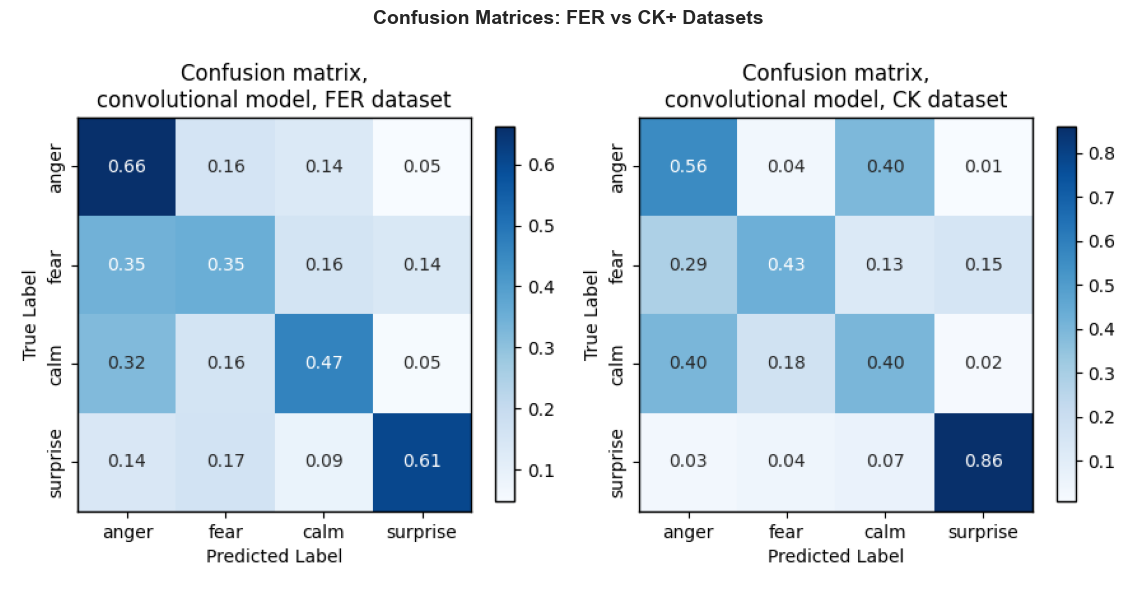


💡 Key Observations:
  • FER dataset shows more confusion between emotions
  • CK+ dataset demonstrates clearer emotion separation
  • Surprise emotion shows strongest recognition in both datasets
  • Fear emotion shows lower performance, especially in FER dataset


In [ ]:
# Load and display confusion matrices
cm_path = os.path.join(BASELINE_MODEL_DIR, 'confusion_matrices_fer_vs_ckp.png')

if os.path.exists(cm_path):
    print("📊 Baseline Model Confusion Matrices:")
    print("="*60)
    print("\nThe confusion matrices show per-class performance for FER and CK+ datasets:")

    # Display the confusion matrices
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    img = Image.open(cm_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Confusion Matrices: FER vs CK+ Datasets', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

    print("\n💡 Key Observations:")
    print("  • FER dataset shows more confusion between emotions")
    print("  • CK+ dataset demonstrates clearer emotion separation")
    print("  • Surprise emotion shows strongest recognition in both datasets")
    print("  • Fear emotion shows lower performance, especially in FER dataset")

---
## Part 3: Dataset Characteristics Analysis

Detailed analysis of demographic distribution patterns in the baseline dataset.

📊 DEMOGRAPHIC CROSS-TABULATION ANALYSIS


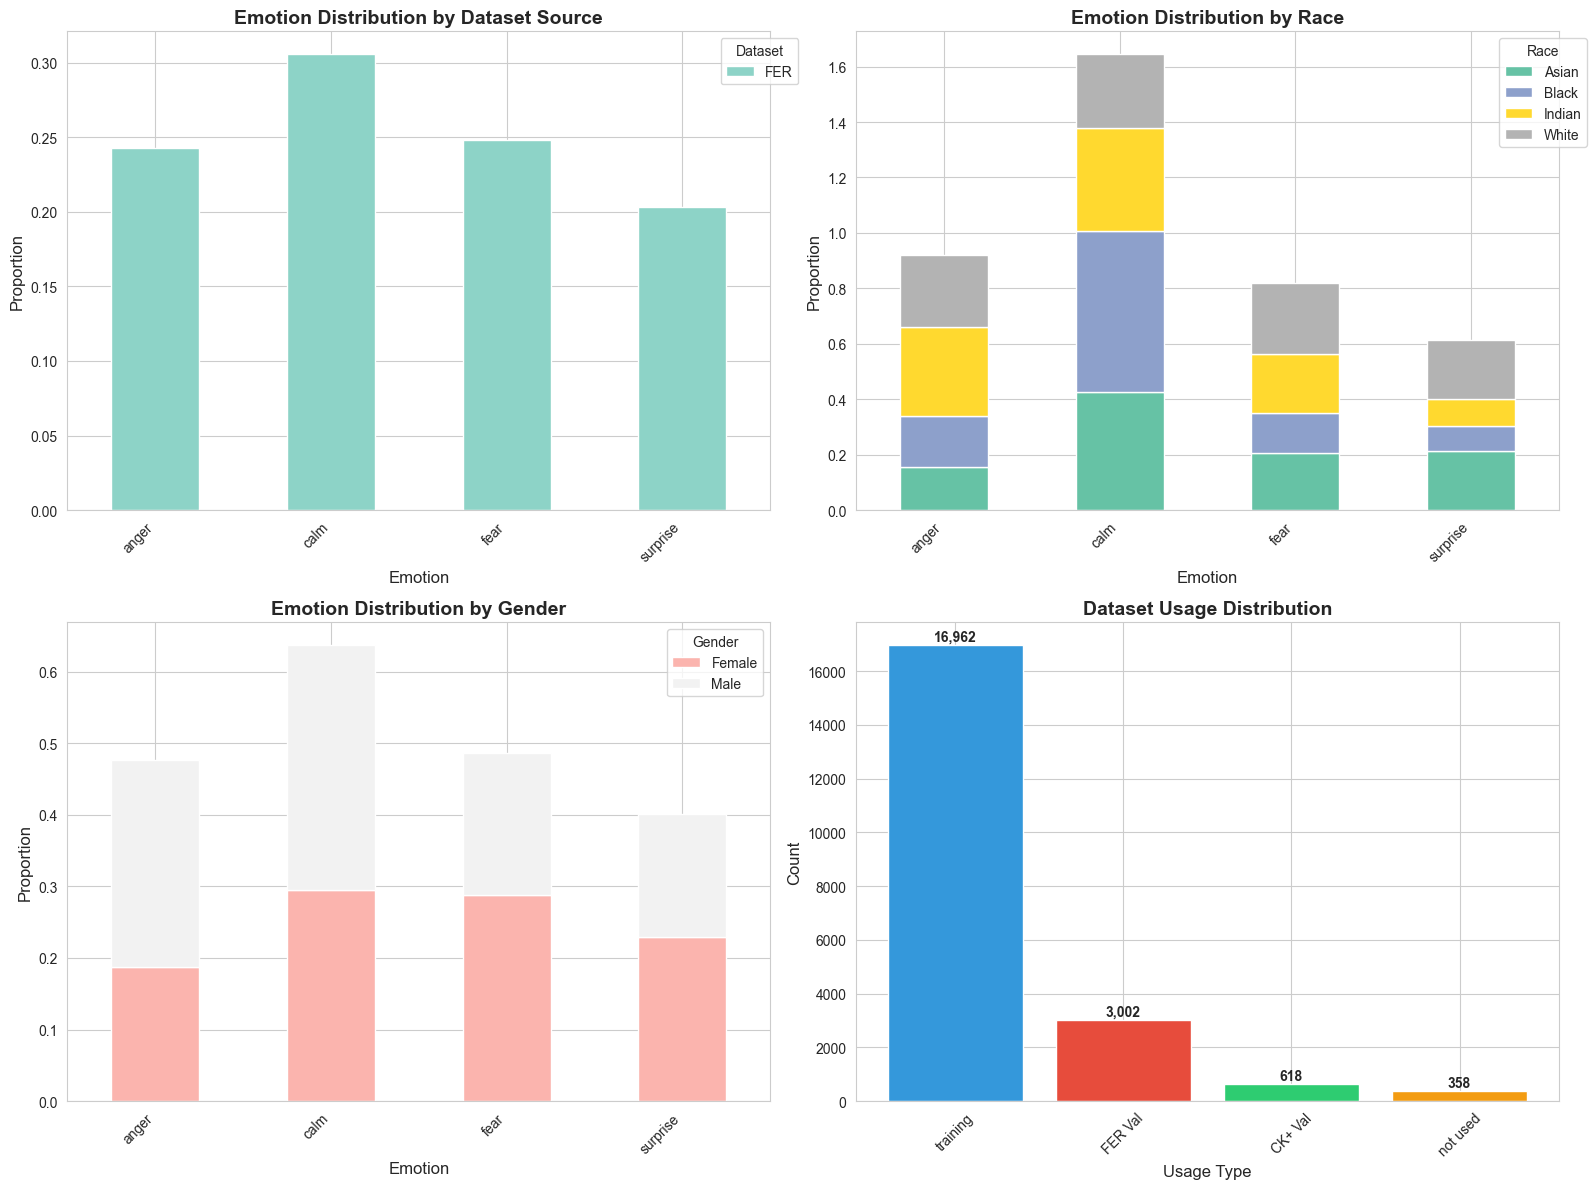

In [ ]:
# Create cross-tabulation analyses
print("📊 DEMOGRAPHIC CROSS-TABULATION ANALYSIS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Emotion by Dataset Source
ax1 = axes[0, 0]
emotion_dataset = pd.crosstab(df['emotion'], df['dataset_source'], normalize='columns')
emotion_dataset.plot(kind='bar', stacked=True, ax=ax1, colormap='Set3')
ax1.set_title('Emotion Distribution by Dataset Source', fontsize=14, fontweight='bold')
ax1.set_xlabel('Emotion', fontsize=12)
ax1.set_ylabel('Proportion', fontsize=12)
ax1.legend(title='Dataset', bbox_to_anchor=(1.05, 1))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Emotion by Race
ax2 = axes[0, 1]
if len(df_race) > 0:
    emotion_race = pd.crosstab(df_race['emotion'], df_race['race4'], normalize='columns')
    emotion_race.plot(kind='bar', stacked=True, ax=ax2, colormap='Set2')
    ax2.set_title('Emotion Distribution by Race', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Emotion', fontsize=12)
    ax2.set_ylabel('Proportion', fontsize=12)
    ax2.legend(title='Race', bbox_to_anchor=(1.05, 1))
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Emotion by Gender
ax3 = axes[1, 0]
if len(df_gender) > 0:
    emotion_gender = pd.crosstab(df_gender['emotion'], df_gender['gender'], normalize='columns')
    emotion_gender.plot(kind='bar', stacked=True, ax=ax3, colormap='Pastel1')
    ax3.set_title('Emotion Distribution by Gender', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Emotion', fontsize=12)
    ax3.set_ylabel('Proportion', fontsize=12)
    ax3.legend(title='Gender')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')

# Usage distribution
ax4 = axes[1, 1]
usage_dist = df['usage'].value_counts()
usage_labels_clean = [usage_mapping.get(x, x) for x in usage_dist.index]
bars4 = ax4.bar(usage_labels_clean, usage_dist.values, color=['#3498DB', '#E74C3C', '#2ECC71', '#F39C12'])
ax4.set_title('Dataset Usage Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Usage Type', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.tick_params(axis='x', rotation=45)

for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 50,
            f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---
## Part 4: Baseline Model Limitations

Summary of identified limitations in the baseline model and dataset.

In [ ]:
print("⚠️ BASELINE MODEL LIMITATIONS SUMMARY")
print("="*80)

print("\n🔍 Model Performance Limitations:")
print("─" * 60)
limitations = [
    ("Low Overall Accuracy", f"{combined_val_acc:.1f}%", "Below industry standards for emotion recognition"),
    ("Dataset-Specific Bias", f"{dataset_gap:.1f}% gap", "Significant performance difference between FER and CK+"),
    ("Limited Generalization", f"{train_acc:.1f}% training", "Close training-validation gap suggests underfitting"),
    ("Fear Recognition Weakness", "Observed in matrices", "Particularly poor in FER dataset")
]

for i, (limitation, value, description) in enumerate(limitations, 1):
    print(f"\n{i}. {limitation}")
    print(f"   Metric: {value}")
    print(f"   Impact: {description}")

print("\n\n📊 Dataset Limitations:")
print("─" * 60)
dataset_limitations = [
    ("Limited Diversity", "Two datasets only (FER, CK+)", "Narrow source variety"),
    ("Demographic Imbalance", "Uneven race/age distribution", "May limit fairness"),
    ("No Augmentation Analysis", "No robustness testing", "Unknown performance under variations")
]

for i, (limitation, detail, impact) in enumerate(dataset_limitations, 1):
    print(f"\n{i}. {limitation}")
    print(f"   Detail: {detail}")
    print(f"   Impact: {impact}")

⚠️ BASELINE MODEL LIMITATIONS SUMMARY

🔍 Model Performance Limitations:
────────────────────────────────────────────────────────────

1. Low Overall Accuracy
   Metric: 53.9%
   Impact: Below industry standards for emotion recognition

2. Dataset-Specific Bias
   Metric: 9.5% gap
   Impact: Significant performance difference between FER and CK+

3. Limited Generalization
   Metric: 57.1% training
   Impact: Close training-validation gap suggests underfitting

4. Fear Recognition Weakness
   Metric: Observed in matrices
   Impact: Particularly poor in FER dataset


📊 Dataset Limitations:
────────────────────────────────────────────────────────────

1. Limited Diversity
   Detail: Two datasets only (FER, CK+)
   Impact: Narrow source variety

2. Demographic Imbalance
   Detail: Uneven race/age distribution
   Impact: May limit fairness

3. No Augmentation Analysis
   Detail: No robustness testing
   Impact: Unknown performance under variations


---
## Summary Statistics

In [ ]:
print("\n" + "="*80)
print("📊 BASELINE MODEL SUMMARY STATISTICS")
print("="*80)

print("\n📈 Performance Overview:")
print(f"  • Best Accuracy: {ckp_val_acc:.2f}% (CK+ validation)")
print(f"  • Worst Accuracy: {fer_val_acc:.2f}% (FER validation)")
print(f"  • Average Validation: {combined_val_acc:.2f}%")
print(f"  • Performance Gap: {dataset_gap:.2f}%")

print("\n📊 Dataset Overview:")
print(f"  • Total Images: {len(df):,}")
print(f"  • Training Images: {len(df[df['usage'].str.contains('training')]):,}")
print(f"  • Validation Images: {len(df[df['usage'].str.contains('validation')]):,}")
print(f"  • Emotions Covered: {len(emotion_counts)}")

print("\n🎯 Key Takeaways:")
print("  • Baseline model provides foundation for comparison")
print("  • Significant room for improvement in accuracy")
print("  • Dataset-specific biases identified")
print("  • Limited demographic fairness analysis available")
print("  • Serves as motivation for Enhanced Model V2 development")

print("\n" + "="*80)
print("📄 BASELINE MODEL ANALYSIS COMPLETE")
print("="*80)


📊 BASELINE MODEL SUMMARY STATISTICS

📈 Performance Overview:
  • Best Accuracy: 60.80% (CK+ validation)
  • Worst Accuracy: 51.29% (FER validation)
  • Average Validation: 53.88%
  • Performance Gap: 9.51%

📊 Dataset Overview:
  • Total Images: 20,940
  • Training Images: 16,962
  • Validation Images: 3,620
  • Emotions Covered: 4

🎯 Key Takeaways:
  • Baseline model provides foundation for comparison
  • Significant room for improvement in accuracy
  • Dataset-specific biases identified
  • Limited demographic fairness analysis available
  • Serves as motivation for Enhanced Model V2 development

📄 BASELINE MODEL ANALYSIS COMPLETE
